In [3]:
#загрузка библиотек
import cv2 # для работы с видео
import math # для математических вычислений
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from google.colab.patches import cv2_imshow


import glob
import sys

from PIL import Image
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

In [4]:
!pip install moviepy


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



     ------------------------------------ 388.3/388.3 kB 969.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 22.6/22.6 MB 4.6 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110773 sha256=8f422c7bcde276d17957a096ec1a41f248c3316b1e5704f6d9d34fcc77da6998
  Stored in directory: c:\users\asus-pc\appdata\local\pip\cache\wheels\29\15\e4\4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [5]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

In [6]:
#вспомогательные функции

#преобразования в тензор
to_tensor = transforms.ToTensor()


#модель
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT #loading weights of pretrained model


model = keypointrcnn_resnet50_fpn(weights=weights, progress=False) #model initialized with the weights
model = model.eval() #switch model to eval mode



#функция для получение опорных точек
#!!!убираем критерий проверки достоверности keypoints (иначе не везде будет 17) + увеличиваем порог уверенности в боксе до 0,95 - иначе будет несколько рамок
def get_keypoints_per_person(
    all_keypoints, all_scores, confs
):

    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        person_id = np.argmax(confs.detach().numpy())
        # собираем ключевые точки конкретного человека
        keypoints = all_keypoints[person_id, ...]
        keypoints = keypoints[:, :2].detach().numpy()
        # собираем скоры для ключевых точек
        scores = all_scores[person_id, ...]


    return  keypoints, scores


# функция для получения аффинного преобразования
def get_affine_transfrom(model_key_points, input_key_points):
  pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
  unpad = lambda x: x[:, :-1]

  Y = pad(model_key_points)
  X = pad(input_key_points)

  A, res, rank, s = np.linalg.lstsq(X, Y)
  A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения
  transform = lambda x: unpad(np.dot(pad(x), A))
  input_key_points_transform = transform(input_key_points)

  return input_key_points_transform


#функция для оценки косиусного сходства
def cosine_distance(pose1, pose2):
    dist = 0
    for ind in range(len(pose1)):
      cossin = pose1[ind].dot(np.transpose(pose2[ind])) / (
          np.linalg.norm(pose1[ind]) * np.linalg.norm(pose2[ind])
      )
      dist+=cossin
    dist = dist/len(pose1)

    return dist

#функция для оценки взвешенного расстояния
def weight_distance(input_key_points_transform, model_key_points, input_confs):

    sum1 = 1 / np.sum(input_confs)
    sum2 = 0

    for ind in range(len(input_key_points_transform)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = math.floor(input_confs[ind] / 2)
        sum2 += input_confs[ind] * np.linalg.norm(abs(input_key_points_transform[ind] - model_key_points[ind]))

    weighted_dist = sum1 * sum2

    return weighted_dist

  #список опорных точек
keypoints_list = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

#список "конечностей"
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs

limbs = get_limbs_from_keypoints(keypoints_list)



def draw_skeleton_per_person(
    img, all_keypoints, all_scores, confs, limbs, keypoint_threshold=2
):
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = np.array(img)
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # индекс наиболее вероятного задетектированного человека
    person_id = np.argmax(confs.detach().numpy())
    keypoints = all_keypoints[person_id, ...]
    kp_list = []
    for kp in range(len(keypoints)):
                   # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    kp_list.append(keypoint)
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 2, color, -1)
            #print(kp_list)
    for limb in limbs:
                cv2.line(img_copy, kp_list[limb[0]], kp_list[limb[1]], color, 1)
    return img_copy

In [7]:
#оценим косинусное сходство и взвешенное расстояние  и выведем на экран два видео с подписью метрик

#читаем два видео
video1 = cv2.VideoCapture('examples/video1.mp4')
video2 = cv2.VideoCapture('examples/video2.mp4')

#считаем width, height and frame rate с первого видео
width = int(video1.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video1.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = int(video1.get(cv2.CAP_PROP_FPS))

#создаем объект VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4',fourcc,1,(width*2,height))

#читаем в цикле кадры из двух видео и записываем сборный кадр
while True:
    ret1, frame1 = video1.read()
    frameId = video1.get(1)

    ret2, frame2 = video2.read()

    if not ret1 or not ret2:
      break
    elif (frameId % math.floor(frame_rate/2) == 0):
      frame2 = cv2.resize(frame2, (width, height)) #меняем размер кадров из 2-го видео, чтобы был такой же, как в 1-м видео


      image_trans_model = to_tensor(frame1) #преобразование изображений
      image_trans_train = to_tensor(frame2) #преобразование изображений


      outputs_model = model([image_trans_model]) #работа модели
      outputs_train = model([image_trans_train]) #работа модели

      #print(outputs[0])
      all_keypoints_model, all_scores_model, confs_model = outputs_model[0]['keypoints'], outputs_model[0]['keypoints_scores'], outputs_model[0]['scores']
      model_key_points = np.array(get_keypoints_per_person(all_keypoints_model, all_scores_model, confs_model)[0])

      all_keypoints_train, all_scores_train, confs_train = outputs_train[0]['keypoints'], outputs_train[0]['keypoints_scores'], outputs_train[0]['scores']
      train_key_points = np.array(get_keypoints_per_person(all_keypoints_train, all_scores_train, confs_train)[0])
      train_confs = np.array(get_keypoints_per_person(all_keypoints_train, all_scores_train, confs_train)[1].detach().numpy())

      train_key_points_transform = get_affine_transfrom(model_key_points, train_key_points) #аффинное преобразование



      canvas = np.zeros((height, width*2, 3), dtype = np.uint8) #создаем черный фон
      canvas[:, :width] = draw_skeleton_per_person(frame1[:, :, ::-1], all_keypoints_model, all_scores_model, confs_model, limbs) #на левой части будет кадр из 1-го видео
      canvas[:, width:] = draw_skeleton_per_person(frame2[:, :, ::-1], all_keypoints_train, all_scores_train, confs_train, limbs) #на правой части будет кадр из 2-го видео



      cv2.putText(canvas, f'cosine_similarity: {round(cosine_distance(model_key_points, train_key_points_transform), 3)}', (width-100, height-30),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA, False)
      cv2.putText(canvas, f'weighted_distance: {round(weight_distance(train_key_points_transform, model_key_points, train_confs), 2)}', (width-100, height-10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA, False)

      out.write(canvas) #записываем сборный кадр

video1.release()
video2.release()
out.release()

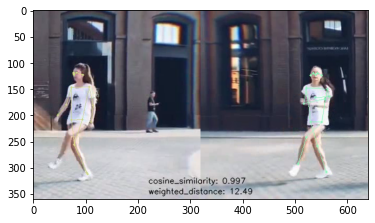

In [8]:
#выведем на экран кадры из получившегося видео

count = 0
videoFile = "output.mp4"
cap = cv2.VideoCapture(videoFile) # загрузка видео , захват видео
frameRate = cap.get(5)


while(cap.isOpened()):
  frameId = cap.get(1) # номер текущего кадра
  ret, frame = cap.read()#возвращает True/False (в зависимости от того, смог ли найти следующий кадр) и сам кадр
  if (ret != True):
      break
  elif (frameId % math.floor(frameRate) == 0):
      plt.imshow(frame)